## Setup

In [1]:
import pandas as pd
import logging 
import sys
import os
sys.path.insert(0,'./src')


from src.utils.logger import sys_logger

os.makedirs("./final_data", exist_ok=True)

## Landing Zone to Staging

In [2]:
from src.utils.splitter import split_files

split_files()

[splitter.py:9]                 Files in landing zone: ['products_20241011.json', 'customer_20241009.csv', 'products_20241010.json', 'sales_20241010.txt', 'sales_20241011.txt', 'sales_20241013.txt', 'sales_20241012.txt', 'sales_20241015.txt', 'sales_20241014.txt', 'products_20241015.json', 'sales_20241009.txt', 'products_20241014.json', 'products_20241009.json', 'customer_20241015.csv', 'products_20241013.json', 'customer_20241014.csv', 'customer_20241010.csv', 'products_20241012.json', 'customer_20241011.csv', 'customer_20241013.csv', 'customer_20241012.csv']
[splitter.py:14]                products_20241011.json matched with product
[splitter.py:17]                products_20241011.json moved to ./data/products/
[splitter.py:14]                customer_20241009.csv matched with customer
[splitter.py:17]                customer_20241009.csv moved to ./data/customer/
[splitter.py:14]                products_20241010.json matched with product
[splitter.py:17]                products_202

## Staging to Tables

In [3]:
from src.utils.ingestion import run_ingestion

run_ingestion()

[watermark.py:8]                Reading watermark table from ./watermark.parquet
[watermark.py:12]               Watermark table not found at ./watermark.parquet. Creating new table
[watermark.py:14]               Watermark table has 0 rows
[ingestion.py:12]               Loading customer data
[watermark.py:18]               Getting last run date for customer
[watermark.py:21]               No previous runs found for customer
[files.py:10]                   Getting files to process from ./data/customer/
[files.py:14]                   Found 7 files to process
[ingestion.py:19]               Processing customer_20241009.csv
[files.py:26]                   Reading csv file from ./data/customer/customer_20241009.csv with kwargs {'sep': ','}
[dataframes.py:134]             Processing data for customer
[files.py:55]                   Getting saved file for customer
[files.py:18]                   Getting save filename for customer
[files.py:34]                   Reading parquet file from ./

## Report Generation

In [4]:
from matplotlib import pyplot as plt

### Customer Growth

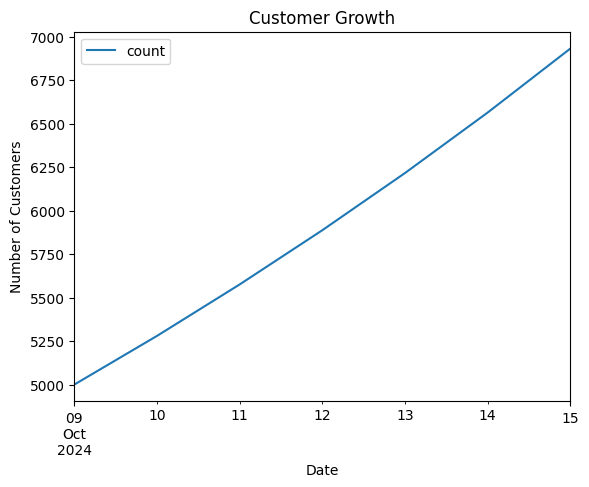

In [5]:
customers = pd.read_parquet('./final_data/customer.parquet')

dates = customers['effective_from'].unique()

data = []
for date in sorted(dates):
    snapshot = customers[(customers['effective_from'] <= date) & (customers['expiry_date'] > date)]
    data.append({'date': date, 'count': len(snapshot)})

df = pd.DataFrame(data)
df.plot(x='date', y='count')
plt.title('Customer Growth')
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.show()

### Sales By Membership

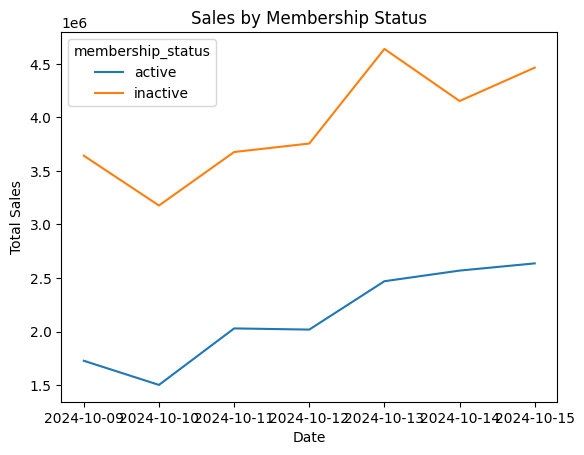

In [6]:
# Sales By Members
customers = pd.read_parquet('./final_data/customer.parquet')

dates = customers['effective_from'].unique()
sales = pd.read_parquet('./final_data/sales.parquet')
merged = sales.merge(customers, on='customer_id', how='outer')
merged = merged[(merged['effective_from_y'] <= merged['sale_date']) & (merged['expiry_date_y'] > merged['sale_date'])]
data = merged.groupby(['sale_date', 'membership_status'])['total_price'].sum().unstack().fillna(0)

data.plot()
plt.title('Sales by Membership Status')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

### Product Sale Breakdown

In [7]:
# pivot of most popular products over time from members vs non-members

products = pd.read_parquet('./final_data/product.parquet')
customers = pd.read_parquet('./final_data/customer.parquet')
sales = pd.read_parquet('./final_data/sales.parquet')

merged = sales.merge(customers, on='customer_id', how='outer')
merged = merged[(merged['effective_from_y'] <= merged['sale_date']) & (merged['expiry_date_y'] > merged['sale_date'])]
merged_with_products = merged.merge(products, on='product_id', how='left')
data = merged_with_products.groupby(['sale_date', 'membership_status', 'name'])['total_price'].sum().unstack().fillna(0)

data

name                              Camera  External Hard Drive  Headphones  \
sale_date  membership_status                                                
2024-10-09 active                   0.00                 0.00        0.00   
           inactive                 0.00                 0.00        0.00   
2024-10-10 active                   0.00                 0.00        0.00   
           inactive                 0.00                 0.00        0.00   
2024-10-11 active                   0.00                 0.00        0.00   
           inactive                 0.00                 0.00        0.00   
2024-10-12 active                   0.00                 0.00   542564.00   
           inactive                 0.00                 0.00  1028280.00   
2024-10-13 active             1912712.40                 0.00   546459.20   
           inactive           3572453.16                 0.00  1053483.20   
2024-10-14 active             2191213.92            143835.64   590544.04   
           inactive           3262410.24            237151.36  1028406.56   
2024-10-15 active             1905392.70            144721.08   557222.40   
           inactive           3307258.20            229886.16   890265.60   

name                               Laptop     Monitor      Mouse     Printer  \
sale_date  membership_status                                                   
2024-10-09 active              7714256.20  1425283.65  205094.40  1388914.80   
           inactive           16059291.36  3232253.43  481219.20  2960967.10   
2024-10-10 active              6033176.45  1316356.72  180747.63  1140371.26   
           inactive           13102433.40  2879737.56  332764.32  2472595.02   
2024-10-11 active              5935608.00  1181432.00  173135.76  1155834.75   
           inactive           10684094.40  2231773.60  315731.36  2439908.10   
2024-10-12 active              5280251.34  1255896.88  167447.28  1133237.07   
           inactive            9652723.08  2266911.36  302211.00  2124191.79   
2024-10-13 active              4290997.62  1222725.00  151603.20  1278061.40   
           inactive            8423324.91  2163420.00  250145.28  2018991.59   
2024-10-14 active              4090971.50  1045593.36  127227.66  1179916.22   
           inactive            6839297.50  1805872.32  228927.44  1955488.92   
2024-10-15 active              3683285.62  1110422.04  156149.07  1074436.44   
           inactive            6248117.26  1670183.97  231034.79  1704604.44   

name                              Router  Smartphone  Smartwatch     Tablet  
sale_date  membership_status                                                 
2024-10-09 active             1356263.16        0.00        0.00       0.00  
           inactive           2758824.46        0.00        0.00       0.00  
2024-10-10 active             1218046.83        0.00   533694.66       0.00  
           inactive           2198976.78        0.00  1072222.26       0.00  
2024-10-11 active             1110109.28  2913344.85   488637.60       0.00  
           inactive           1983107.84  4937994.10  1000088.10       0.00  
2024-10-12 active              922285.98  2713591.55   531843.30       0.00  
           inactive           1627122.42  5344715.05   885710.28       0.00  
2024-10-13 active              833729.96  2549503.60   448796.70       0.00  
           inactive           1531708.50  4846424.80   960468.30       0.00  
2024-10-14 active              850611.58  2531520.25   425252.52       0.00  
           inactive           1298721.97  4124345.40   791182.98       0.00  
2024-10-15 active              711252.92  2425675.30   386894.04  277844.45  
           inactive           1223078.36  4177334.20   695503.50  490363.64